# Feature Engineering
Carefully teasing out patterns in the corpus is a key part of natural language processing. Cleaning is all done, so now it's time to get things that a human speaker would know out of the data. The result of this notebook is a large csv. From here, the data goes into two paths: the unsupervised path and the supervised path.

In [93]:
import pandas as pd
import numpy as np
import re

import seaborn as sns
import matplotlib.pyplot as plt

In [94]:
%run ../scripts/post_scraping_text_processing.py functions

Text processing functions loaded.


In [144]:
df = pd.read_csv("../assets/data/assembled_20180711.csv", index_col=0)

In [145]:
df.columns

Index(['artist', 'album', 'text', 'release', 'name', 'year',
       'written_before_2002', 'written_before_2004', 'written_before_2006',
       'written_before_2008'],
      dtype='object')

In [146]:
df.loc[52145,'text'].lower()

'ellemeyin beni bu gece dostlar çok büyük derdim var i̇çimdeki boşluk içkiyle doldu benim kendime kastım var dönse de dünya artık çevremde durmuyor ruhum bu süslü bedende ve yine o şişe yine elimde tükensin artık ellemeyin beni ah bu zamanlar çok büyük derdim var i̇çimdeki boşluk içkiyle doldu benim kendime kastım var'

## Vocables: Non-lexical words
Turkish songs use certain sounds that don't carry strict lexical meaning, but are expressions of grief or are just good musical material. We should include some scripting to figure out if there's any pattern in the use of these vocables. I've picked 5 common vocables: `oy`, `ah`, `ey`, `vay`, and `oh`. For each, I'm making a column for the total amount of characters that each song spends on these vocables as well as replacing them in the corpus.

In [147]:
# First the vocable patterns: each vocable can have 1+ of all the characters in it, with the h's optional in ah
vocable_patterns = {
    'oy':  r'\bo+y+\b',
    'ah':  r'\ba+h*\b',
    'ey':  r'\be+y+\b',
    'vay': r'\bva+y+\b',
    'oh':  r'\bo+h+\b',
}

In [148]:
def vocable_counter(text, vocable_pattern = r'\bo+h+\b'):
    list_of_vocables = re.findall(vocable_pattern, text.lower())
    if list_of_vocables != None:
        len_voc = 0
        for match in list_of_vocables:
            len_voc += len(match)
        return len_voc
    else:
        return 0
    
def vocable_encoder(text, vocable_pattern = r'\bo+h+\b'):
    text = text.lower()
    list_of_vocables = re.findall(vocable_pattern, text)
    if list_of_vocables != None:
        for match in list_of_vocables:
            text = re.sub(match, key, text)
        return text
    else:
        return text

In [149]:
test = 'Ellemeyin beni bu gece dostlar Çok büyük derdim var İçimdeki boşluk içkiyle doldu Benim kendime kastım var Dönse de dünya artık çevremde Durmuyor ruhum bu süslü bedende Ve yine o şişe yine elimde Tükensin artık Ellemeyin beni ah bu zamanlar Çok büyük derdim var İçimdeki boşluk içkiyle doldu Benim kendime kastım var'

In [150]:
vocable_counter(test, r'\bo+h+\b')

0

In [151]:
vocable_encoder(test, r'\bo+h+\b')

'ellemeyin beni bu gece dostlar çok büyük derdim var i̇çimdeki boşluk içkiyle doldu benim kendime kastım var dönse de dünya artık çevremde durmuyor ruhum bu süslü bedende ve yine o şişe yine elimde tükensin artık ellemeyin beni ah bu zamanlar çok büyük derdim var i̇çimdeki boşluk içkiyle doldu benim kendime kastım var'

In [152]:
# Next the counter. For each key in the dictionary above this loop makes a new column.
for key, value in vocable_patterns.items():
    def vocable_counter(text, vocable_pattern = value):
        list_of_vocables = re.findall(vocable_pattern, text.lower())
        if list_of_vocables != None:
            len_voc = 0
            for match in list_of_vocables:
                len_voc += len(match)
            return len_voc
        else:
            return 0
    df[key+'_length'] = df['text'].map(vocable_counter)

In [153]:
# Finally, a loop to replace all the long drawn out vocables with a simple short version

for key, value in vocable_patterns.items():
    def vocable_encoder(text, vocable_pattern = value):
        text = text.lower()
        list_of_vocables = list(re.findall(vocable_pattern, text))
        if list_of_vocables != None:
            for match in list_of_vocables:
                text = re.sub(match, key, text)
        return text
    df['text'] = df['text'].map(vocable_encoder)

In [154]:
df.loc[52145,'text']

'ellemeyin beni bu gece dostlar çok büyük derdim var i̇çimdeki boşluk içkiyle doldu benim kendime kastım var dönse de dünya artık çevremde durmuyor ruhum bu süslü bedende ve yine o şişe yine elimde tükensin artık ellemeyin beni ah bu zamanlar çok büyük derdim var i̇çimdeki boşluk içkiyle doldu benim kendime kastım var'

In [155]:
df['text'] = df['text'].map(lambda x: re.sub('i̇', 'i', x))

In [156]:
df.loc[38252,'text']

'insanlar kendini bilebilseydi dünyada haksızlık kavga olmazdı insan doğan yine insan ölseydi belki de dünyada hayvan kalmazdı hayvanlar yabanda sürüsüyünen geçinemez biri birisiyen insan cennetinin hurisiyinen sevişseydi hak yabana salmazdı tüm canların hak olduğun bilmese hakkın aşkı yüreğine dolmasa o güzel cemale aşık olmasa kul garibim bu sazını çalmazdı söz&müzik neşet ertaş'

## Some other simple features
- longest word
- total words
- how many words are repeated
- how many bigrams are repeated
- most common bigram

In [157]:
def find_longest_word(text):
    """Finds the longest word in a lyric"""
    r = 0
    for i in text.split():
        if len(i) > r:
            r = len(i)
    return r

In [158]:
df['longest_word_length'] = df['text'].map(find_longest_word)

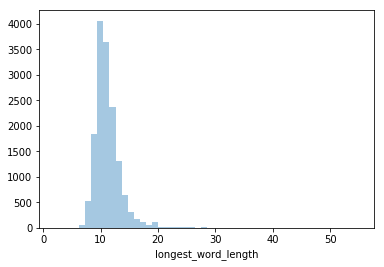

In [159]:
sns.distplot(df['longest_word_length'], kde = False)

In [160]:
df['total_words'] = df['text'].map(lambda x: len(x.split()))

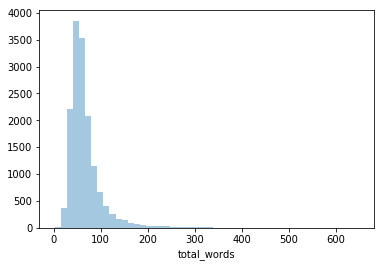

In [161]:
sns.distplot(df['total_words'], kde = False)

In [162]:
def count_repeated_words(text):
    text = re.sub(r"[,.?'\"\\]", "", text)
    text = text.lower().split()
    count = 0
    for word in list(set(text)):
        count += (text.count(word) - 1)
    return count

In [163]:
def make_bigrams(text):
    text = re.sub(r"[,.?'\"\\]", "", text)
    text = text.lower().split()
    return [f"{i} {j}" for i,j in zip(text[:-1], text[1:])]
        

In [164]:
def count_repeated_bigrams(text):
    bigrams = make_bigrams(text)
    count = 0
    for bigram in list(set(bigrams)):
        count += (bigrams.count(bigram) - 1)
    return count

In [165]:
df['repeated_exact_words'] = df['text'].map(count_repeated_words)

In [166]:
df['repeated_bigrams'] = df['text'].map(count_repeated_bigrams)

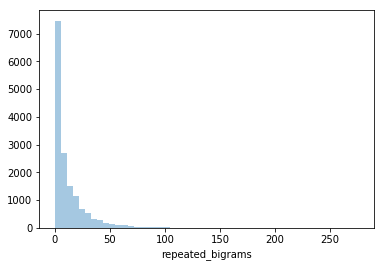

In [167]:
sns.distplot(df['repeated_bigrams'], kde = False)

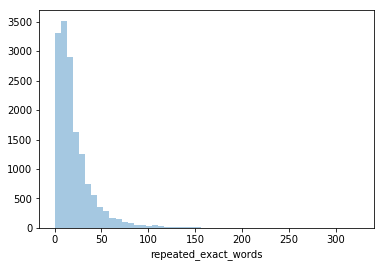

In [168]:
sns.distplot(df['repeated_exact_words'], kde = False)

In [169]:
def get_most_common_bigram(text):
    bigrams = make_bigrams(text)
    most = 0
    most_common_bigram = None
    for bigram in list(set(bigrams)):
        if (bigrams.count(bigram) - 1) > most:
            most = (bigrams.count(bigram) - 1)
            most_common_bigram = bigram
    if most > 1:
        return most_common_bigram
    else:
        return None

df['most_common_bigram'] = df['text'].map(get_most_common_bigram)

In [170]:
df['most_common_bigram'].head()

285    yoktur hey
286          None
289          None
292          None
296      allah ey
Name: most_common_bigram, dtype: object

In [171]:
temp_df = pd.DataFrame(df['most_common_bigram'].value_counts())

temp_df.head(20)

,most_common_bigram
aman aman,84
vay vay,39
oy oy,37
bir gün,36
gel gel,32
yar yar,30
bu gece,26
ne olur,23
beni beni,21
bir daha,21


In [172]:
aman_aman = df[df['most_common_bigram'] == 'aman aman']

In [174]:
1 - aman_aman['written_before_2002'].mean()

0.6428571428571428

In [175]:
def get_most_common_non_repeated_bigram(text):
    bigrams = make_bigrams(text)
    most = 0
    most_common_bigram = None
    for bigram in list(set(bigrams)):
        if (bigram.split()[0] != bigram.split()[1]) and ((bigrams.count(bigram) - 1) > most):
            most = (bigrams.count(bigram) - 1)
            most_common_bigram = bigram
    if most > 1:
        return most_common_bigram
    else:
        return None

df['most_common_non_repeated_bigram'] = df['text'].map(get_most_common_non_repeated_bigram)
temp_df = pd.DataFrame(df['most_common_non_repeated_bigram'].value_counts())
temp_df.head()

,most_common_non_repeated_bigram
bir gün,36
bu gece,28
ne olur,24
bir daha,23
ben sana,14


In [176]:
pre = df[df['written_before_2002'] == 1]
post = df[df['written_before_2002'] == 0]

In [177]:
pd.DataFrame(pre['most_common_non_repeated_bigram'].value_counts()).head()

,most_common_non_repeated_bigram
bir daha,11
bir gün,11
ne olur,10
ben sana,7
bu gece,7


In [178]:
pd.DataFrame(post['most_common_non_repeated_bigram'].value_counts()).head()

,most_common_non_repeated_bigram
bir gün,25
bu gece,21
ne olur,14
bir daha,12
senin için,10


## Lemmatized versions of these features
- number of repeated lemmas
- number of repeated lemma bigrams
- most common lemma bigram
- most common non-repeated lemma bigram

In [179]:
df['lemmatized_text'] = df['text'].map(lemmatize)

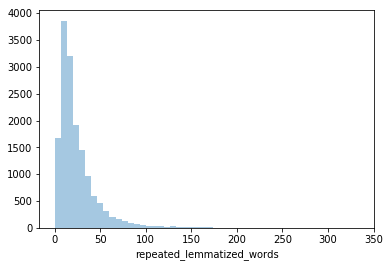

In [180]:
df['repeated_lemmatized_words'] = df['lemmatized_text'].map(count_repeated_words)

sns.distplot(df['repeated_lemmatized_words'], kde = False)

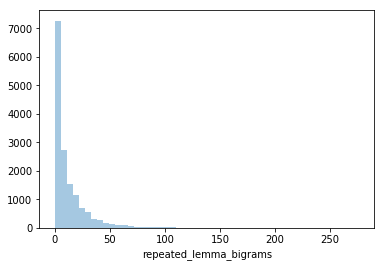

In [181]:
df['repeated_lemma_bigrams'] = df['lemmatized_text'].map(count_repeated_bigrams)
sns.distplot(df['repeated_lemma_bigrams'], kde = False)

In [182]:
df['most_common_lemma_bigram'] = df['lemmatized_text'].map(get_most_common_bigram)
temp_df = pd.DataFrame(df['most_common_lemma_bigram'].value_counts())
temp_df.head(5)

,most_common_lemma_bigram
aman aman,83
ne ol,62
ben ben,42
bir gün,40
sen ben,40


In [183]:
df['most_common_non_repeated_lemma_bigram'] = df['lemmatized_text'].map(get_most_common_non_repeated_bigram)
temp_df = pd.DataFrame(df['most_common_non_repeated_lemma_bigram'].value_counts())
temp_df.head(5)

,most_common_non_repeated_lemma_bigram
ne ol,63
sen ben,41
bir gün,40
bu gece,34
bir yan,29


In [184]:
df.columns

Index(['artist', 'album', 'text', 'release', 'name', 'year',
       'written_before_2002', 'written_before_2004', 'written_before_2006',
       'written_before_2008', 'oy_length', 'ah_length', 'ey_length',
       'vay_length', 'oh_length', 'longest_word_length', 'total_words',
       'repeated_exact_words', 'repeated_bigrams', 'most_common_bigram',
       'most_common_non_repeated_bigram', 'lemmatized_text',
       'repeated_lemmatized_words', 'repeated_lemma_bigrams',
       'most_common_lemma_bigram', 'most_common_non_repeated_lemma_bigram'],
      dtype='object')

### About this dataframe:
- numeric features:
 - longest_oy, longest_ah, longest_ey, longest_vay, longest_oh, 
 - longest_word_length, total_words
 - repeated_exact_words, repeated_bigrams
 - repeated_lemmatized_words, repeated_lemma_bigrams
- categorical features
 - most_common_bigram, most_common_non_repeated_bigram
 - most_common_lemma_bigram, most_common_non_repeated_lemma_bigram

In [185]:
df.fillna('na', inplace=True)

In [187]:
df.to_csv("../assets/data/full_frame_20180711.csv")